# 1. 라이브러리 및 데이터 읽어오기

## 라이브러리 설치

In [1]:
# pip install -qU pandas scikit-learn imblearn keras tensorflow matplotlib

## 모듈 읽어오기

In [2]:
%whos

Interactive namespace is empty.


In [3]:
# ============================================
# 기본 유틸
# ============================================
from datetime import datetime
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# ============================================
# 데이터 전처리 및 평가
# ============================================
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    accuracy_score,
    f1_score
)
from imblearn.over_sampling import SMOTE

In [5]:
# ============================================
# 딥러닝 (TensorFlow / Keras)
# ============================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [6]:
# ============================================
# 모델 저장 / 로드
# ============================================
import joblib
import os

## 분석 데이터 읽어오기

In [7]:
DATA_DIR = Path('data')
DATA_DIR.mkdir(exist_ok=True, parents=True)

data_path = DATA_DIR / 'melting_tank.csv'

In [8]:
data_path

WindowsPath('data/melting_tank.csv')

In [9]:
df = pd.read_csv(data_path)
df

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 0:00,0,489,116,631,3.19,OK
1,2020-03-04 0:00,1,433,78,609,3.19,OK
2,2020-03-04 0:00,2,464,154,608,3.19,OK
3,2020-03-04 0:00,3,379,212,606,3.19,OK
4,2020-03-04 0:00,4,798,1736,604,3.21,OK
...,...,...,...,...,...,...,...
835195,2020-04-30 23:59,835195,755,1743,318,3.21,OK
835196,2020-04-30 23:59,835196,385,206,317,3.19,OK
835197,2020-04-30 23:59,835197,465,148,316,3.20,OK
835198,2020-04-30 23:59,835198,467,0,314,3.19,OK


# 2. 데이터 특성 파악

### 기본 데이터 구조 파악

In [10]:
df.head()

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 0:00,0,489,116,631,3.19,OK
1,2020-03-04 0:00,1,433,78,609,3.19,OK
2,2020-03-04 0:00,2,464,154,608,3.19,OK
3,2020-03-04 0:00,3,379,212,606,3.19,OK
4,2020-03-04 0:00,4,798,1736,604,3.21,OK


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835200 entries, 0 to 835199
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   STD_DT       835200 non-null  object 
 1   NUM          835200 non-null  int64  
 2   MELT_TEMP    835200 non-null  int64  
 3   MOTORSPEED   835200 non-null  int64  
 4   MELT_WEIGHT  835200 non-null  int64  
 5   INSP         835200 non-null  float64
 6   TAG          835200 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 44.6+ MB


In [12]:
df.describe()

,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP
count,835200.000000,835200.000000,835200.000000,835200.000000,835200.000000
mean,417599.500000,509.200623,459.782865,582.962125,3.194853
std,241101.616751,128.277519,639.436413,1217.604433,0.011822
min,0.000000,308.000000,0.000000,0.000000,3.170000
25%,208799.750000,430.000000,119.000000,186.000000,3.190000
50%,417599.500000,469.000000,168.000000,383.000000,3.190000
75%,626399.250000,502.000000,218.000000,583.000000,3.200000
max,835199.000000,832.000000,1804.000000,55252.000000,3.230000


### 시간 정보 datetime 형태 변환 및 인덱스 지정
- STD_DT 변수 타입 변경: Object -> datetime

In [13]:
df['STD_DT'] = pd.to_datetime(df['STD_DT'], errors='coerce')

In [14]:
## STD_DT 타입변경 확인: datetime64[ns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835200 entries, 0 to 835199
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   STD_DT       835200 non-null  datetime64[ns]
 1   NUM          835200 non-null  int64         
 2   MELT_TEMP    835200 non-null  int64         
 3   MOTORSPEED   835200 non-null  int64         
 4   MELT_WEIGHT  835200 non-null  int64         
 5   INSP         835200 non-null  float64       
 6   TAG          835200 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 44.6+ MB


In [15]:
df.STD_DT

0        2020-03-04 00:00:00
1        2020-03-04 00:00:00
2        2020-03-04 00:00:00
3        2020-03-04 00:00:00
4        2020-03-04 00:00:00
                 ...        
835195   2020-04-30 23:59:00
835196   2020-04-30 23:59:00
835197   2020-04-30 23:59:00
835198   2020-04-30 23:59:00
835199   2020-04-30 23:59:00
Name: STD_DT, Length: 835200, dtype: datetime64[ns]

In [16]:
## STD_DT를 인덱스로 지정
df = df.set_index(['STD_DT'])

In [17]:
df.head(5)

,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
STD_DT,,,,,,
2020-03-04,0,489,116,631,3.19,OK
2020-03-04,1,433,78,609,3.19,OK
2020-03-04,2,464,154,608,3.19,OK
2020-03-04,3,379,212,606,3.19,OK
2020-03-04,4,798,1736,604,3.21,OK


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 835200 entries, 2020-03-04 00:00:00 to 2020-04-30 23:59:00
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   NUM          835200 non-null  int64  
 1   MELT_TEMP    835200 non-null  int64  
 2   MOTORSPEED   835200 non-null  int64  
 3   MELT_WEIGHT  835200 non-null  int64  
 4   INSP         835200 non-null  float64
 5   TAG          835200 non-null  object 
dtypes: float64(1), int64(4), object(1)
memory usage: 44.6+ MB


In [19]:
df.index

DatetimeIndex(['2020-03-04 00:00:00', '2020-03-04 00:00:00',
               '2020-03-04 00:00:00', '2020-03-04 00:00:00',
               '2020-03-04 00:00:00', '2020-03-04 00:00:00',
               '2020-03-04 00:00:00', '2020-03-04 00:00:00',
               '2020-03-04 00:00:00', '2020-03-04 00:00:00',
               ...
               '2020-04-30 23:59:00', '2020-04-30 23:59:00',
               '2020-04-30 23:59:00', '2020-04-30 23:59:00',
               '2020-04-30 23:59:00', '2020-04-30 23:59:00',
               '2020-04-30 23:59:00', '2020-04-30 23:59:00',
               '2020-04-30 23:59:00', '2020-04-30 23:59:00'],
              dtype='datetime64[ns]', name='STD_DT', length=835200, freq=None)

### Histogram 및 Plot 그리기

#### 관측치의 구간별 빈도수 확인
- TAG: 클래스(OK/NG 비율 불균형)
    - 문제: 모델이 한 범주로 패턴 분류를 많이하게 됨
    - 해결: 정규화 후에 SMOTE를 통해 불균형 해결

In [20]:
col_name = ['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP', 'TAG']

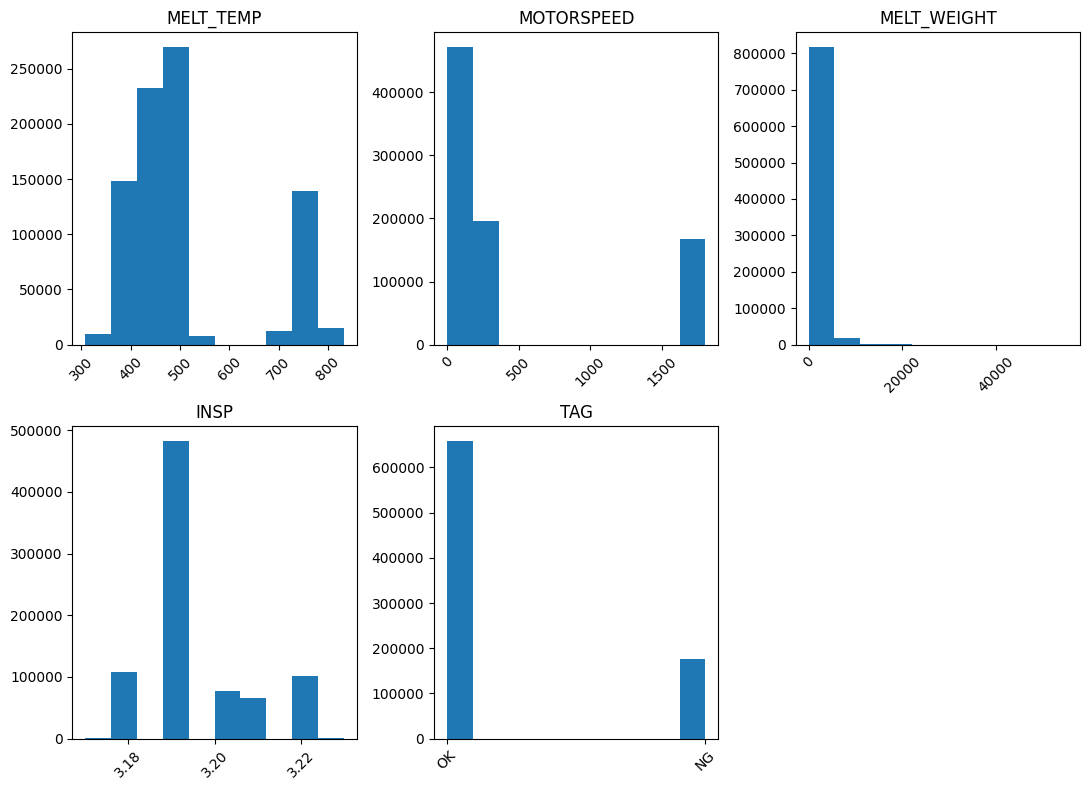

In [21]:
plt.figure(figsize=(11, 8))

## 2행, 3열
## 231: 2행, 3열의 첫 번째 subplot
for i in range(len(col_name)):
    num = 231 + i
    plt.subplot(num)
    plt.hist(df[col_name[i]])
    plt.xticks(rotation=45)
    plt.title(col_name[i])

plt.tight_layout() ## subplot 간격 자동 조절
plt.show()

#### 관측치의 패턴 확인
1) 관측값이 너무 많아서 그래프 패턴 파악 어려움

<Figure size 800x800 with 0 Axes>

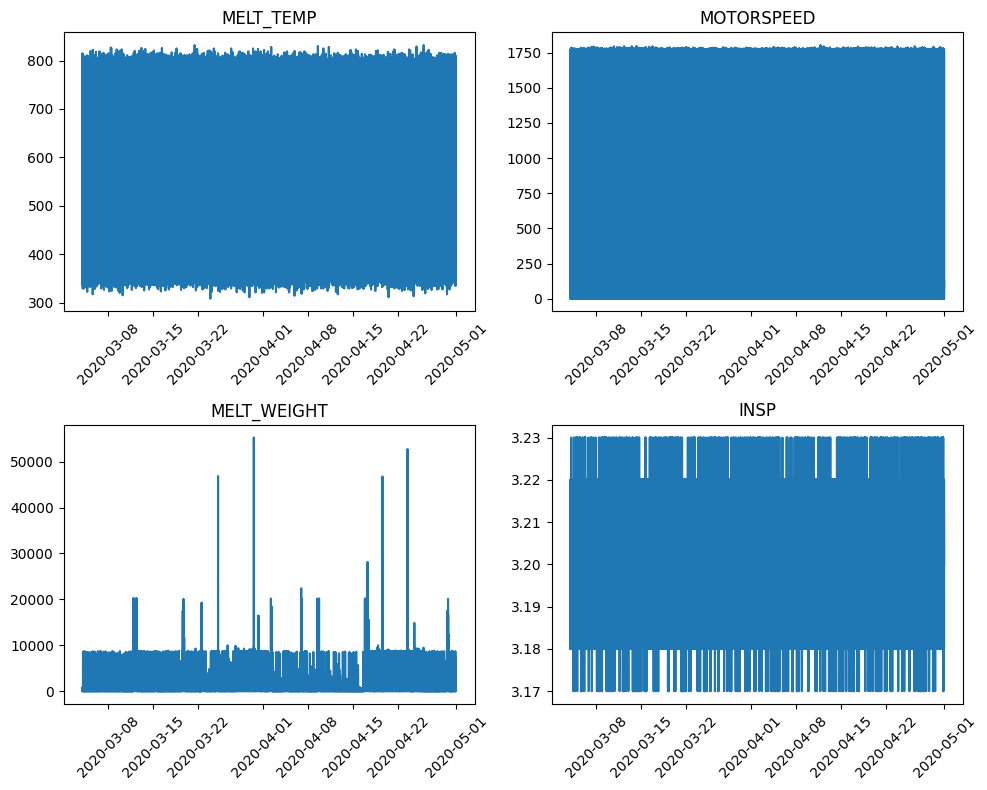

In [22]:
col_name = ['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP']
plt.figure(figsize=(8, 8))

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()  # 2x2 배열을 1차원으로 펼침

for i, col in enumerate(col_name):
    axes[i].plot(df[col])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

2) 관측값 슬라이싱
- 인덱스 0~99: 총 100개
- 전체 데이터 중 일부 구간만 줌인(zoom in)하여 시각화

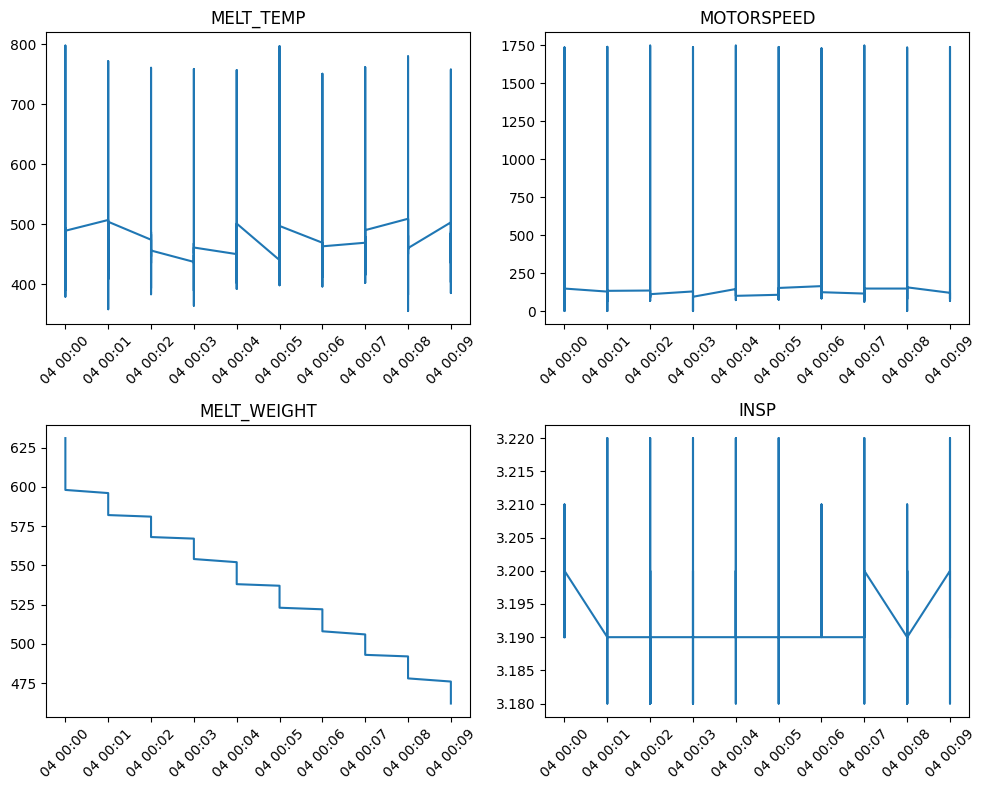

In [23]:
col_name = ['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP']

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()  # 2x2 배열을 1차원으로 펼침

# 시각화 구간 설정 (동적으로 변경 가능)
start, end = 0, 100   # 또는 datetime 인덱스로도 가능

for i, col in enumerate(col_name):
    # axes[i].plot(df[col])
    sliced_data = df[col][start:end]
    axes[i].plot(sliced_data.index, sliced_data.values)
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 범주형 변수를 숫자 형태로 인코딩 
- 종속변수 TAG
  - 범주형 --> 숫자형으로 인코딩
  - OK --> 1
  - NG --> 0

In [24]:
df.TAG.head(3)

STD_DT
2020-03-04    OK
2020-03-04    OK
2020-03-04    OK
Name: TAG, dtype: object

In [25]:
df.TAG.value_counts()

TAG
OK    658133
NG    177067
Name: count, dtype: int64

In [26]:
encoder = LabelEncoder()
df['TAG'] = encoder.fit_transform(df.TAG) ## 범주형 변수를 숫자형으로 인코딩
df['TAG'] = df.TAG.astype('float32')

In [27]:
df.TAG.head(3)

STD_DT
2020-03-04    1.0
2020-03-04    1.0
2020-03-04    1.0
Name: TAG, dtype: float32

In [28]:
df.TAG.value_counts()

TAG
1.0    658133
0.0    177067
Name: count, dtype: int64

### 상관분석(Correlation Analysis)
- 종속변수 TAG와 각 독립변수 간의 상관관계
- corr()
  - 선형 관계(linear relationship) 정도를 -1 ~ 1 사이의 값으로 수치화
  - pearson: 피어슨 상관계수(Pearson correlation coefficient)
    - 1.0 : 완벽한 양(+)의 선형관계, 한쪽이 증가하면 다른 쪽도 증가
    - 0.0 : 상관 없음, 서로 독립적
    - -1.0: 완벽한 음(-)의 선형관계, 한쪽이 증가혐 다른 쪽은 감소

In [29]:
corr = df.corr(method = 'pearson')
corr

,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
NUM,1.000000,0.000188,-0.000050,0.080079,-0.000524,0.086698
MELT_TEMP,0.000188,1.000000,0.944929,-0.000336,0.916295,0.310586
MOTORSPEED,-0.000050,0.944929,1.000000,0.000123,0.887813,0.264693
MELT_WEIGHT,0.080079,-0.000336,0.000123,1.000000,-0.000005,-0.012084
INSP,-0.000524,0.916295,0.887813,-0.000005,1.000000,0.272580
TAG,0.086698,0.310586,0.264693,-0.012084,0.272580,1.000000


#### 상관분석 결과 요약

##### 종속변수 TAG와 각 독립변수 간의 상관관계 해석
| 독립 변수 | 상관계수 | 해석 |
|------------|-----------|------|
| **MELT_TEMP ↔ TAG** | **0.3106** | 약한 **양의 상관관계**  <br>- 용해 온도가 높을수록 제품이 정상(OK)일 가능성이 다소 높음 <br>- 온도 상승이 일정 수준 이상 유지될 때 안정적인 용해 상태를 나타냄 |
| **MOTORSPEED ↔ TAG** | **0.2647** | 약한 **양의 상관관계** <br>- 모터 속도가 빠를수록 OK 비율이 조금 증가하는 경향 <br>- 일정 속도 이상일 때 교반 효율이 높아지며 품질 안정에 기여할 수 있음 |
| **MELT_WEIGHT ↔ TAG** | **-0.0120** | 거의 **무상관** <br>- 중량 변화는 정상/불량 여부에 직접적인 영향을 주지 않음 <br>- 중량보다는 온도·속도·시간 등의 공정 제어 요인이 더 중요 |
| **INSP ↔ TAG** | **0.2726** | 약한 **양의 상관관계** <br>- 생산품의 수분함유량(%)이 높을수록 OK 확률이 약간 증가 <br>- 검사 측정값이 품질 안정성과 연관된 지표일 가능성이 있음 |

##### **요약**
- 상관분석 결과, **TAG**(정상: OK / 불량: NG)는 다른 변수들과 **약한 양(+)의 상관관계(0.2~0.3 수준)** 를 보임  
- 이는 불량 여부가 단일 변수보다는 **온도, 속도, 수분함유량 등 복합적인 공정 요인**에 의해 결정됨을 의미
- 상관계수가 0.3 이하로 낮으므로, **단일 변수의 영향보다는 복합적 공정 패턴**을 분석해야 함  
- **도메인 기반(공정적)** 으로는 **INSP(수분함유량)** 은 온도·속도와 함께 **공정 품질 안정화의 핵심 지표**로 작용할 가능성이 높음  
- 따라서 **시계열 기반 품질 예측 모델(LSTM, GRU 등)** 을 통해 시간에 따른 변수 간 변화 패턴을 함께 고려하는 접근 필요

<br>

---

##### 주요 변수 간 상관관계 해석
 | 변수쌍 | 상관계수 | 해석 |  
 |:--|--|--|
| **MELT_TEMP ↔ MOTORSPEED** | **0.9449** | 매우 강한 **양의 상관관계** — 온도가 높을수록 모터 속도도 함께 증가하는 경향 |
| **MELT_TEMP ↔ INSP** | **0.9163** | 강한 **양의 상관관계** — 용해 온도가 높을수록 INSP(검사값)도 상승 |
| **MOTORSPEED ↔ INSP** | **0.8879** | 상당히 높은 **양의 상관관계** — 속도와 검사값 간에도 밀접한 관계 |
| **MELT_WEIGHT ↔ 다른 변수들** | **≈ 0.00** | 거의 **무상관** — 중량 변화는 다른 변수에 큰 영향을 주지 않음 |
| **TAG ↔ MELT_TEMP** | **0.31** | 약한 **양의 상관** — 온도가 높을수록 `TAG(OK/NG)` 결과에 약간의 차이 존재 |
| **TAG ↔ MOTORSPEED** | **0.26** | 약한 **양의 상관** — 모터 속도가 높을수록 OK일 가능성이 조금 증가 |
| **TAG ↔ INSP** | **0.27** | 약한 **양의 상관** — 생산품의 수분함유량(%)이 높을수록 OK 확률이 약간 증가할 수 있음 |


##### **요약**
- **MELT_TEMP**, **MOTORSPEED**, **INSP** 세 변수는 서로 **강한 양의 상관관계**를 보임  
  - 동일한 공정 상태(예: 용해 과정의 온도 상승 → 모터 가속 → 생산품의 수분함유량 상승)를 반영하는 패턴으로 해석 가능
- **MELT_WEIGHT**는 다른 변수와 거의 독립적인 경향
- **TAG(정상/불량)** 과의 상관은 전반적으로 약함(0.2~0.3 수준)  
  - 이는 불량 여부가 단일 요인이 아닌 **복합적인 변수 조합과 시계열 패턴**에 의해 결정될 가능성을 시사함



##### **해석 포인트**  
- 상관분석만으로는 인과관계를 단정할 수 없으며,  
- 공정 내의 시계열적 변화(LSTM, TCN 등)를 함께 고려한 모델링이 필요합니다.



# 3. 데이터 전처리

## 분석에 활용할 칼럼 추출

In [30]:
df1 = df[['MELT_TEMP', 'MOTORSPEED', 'TAG']]
df1

,MELT_TEMP,MOTORSPEED,TAG
STD_DT,,,
2020-03-04 00:00:00,489,116,1.0
2020-03-04 00:00:00,433,78,1.0
2020-03-04 00:00:00,464,154,1.0
2020-03-04 00:00:00,379,212,1.0
2020-03-04 00:00:00,798,1736,1.0
...,...,...,...
2020-04-30 23:59:00,755,1743,1.0
2020-04-30 23:59:00,385,206,1.0
2020-04-30 23:59:00,465,148,1.0


# 4. 훈련/테스트 데이터 분리

In [31]:
train, test = train_test_split(
    df1, test_size=0.3, shuffle=False
)

train.index.min(), train.index.max(), test.index.min(), test.index.max()

(Timestamp('2020-03-04 00:00:00'),
 Timestamp('2020-04-13 14:23:00'),
 Timestamp('2020-04-13 14:24:00'),
 Timestamp('2020-04-30 23:59:00'))

In [32]:
train.shape, test.shape

((584640, 3), (250560, 3))

In [33]:
train

,MELT_TEMP,MOTORSPEED,TAG
STD_DT,,,
2020-03-04 00:00:00,489,116,1.0
2020-03-04 00:00:00,433,78,1.0
2020-03-04 00:00:00,464,154,1.0
2020-03-04 00:00:00,379,212,1.0
2020-03-04 00:00:00,798,1736,1.0
...,...,...,...
2020-04-13 14:23:00,748,1737,1.0
2020-04-13 14:23:00,381,216,1.0
2020-04-13 14:23:00,474,148,1.0


In [34]:
test

,MELT_TEMP,MOTORSPEED,TAG
STD_DT,,,
2020-04-13 14:24:00,485,128,1.0
2020-04-13 14:24:00,428,77,0.0
2020-04-13 14:24:00,450,168,0.0
2020-04-13 14:24:00,361,186,1.0
2020-04-13 14:24:00,763,1753,1.0
...,...,...,...
2020-04-30 23:59:00,755,1743,1.0
2020-04-30 23:59:00,385,206,1.0
2020-04-30 23:59:00,465,148,1.0


# 5. 정규화

## 정규화(Normalization)
- 데이터의 단위 차이를 없애고, 모델이 모든 변수의 패턴을 균등하게 학습하도록 도와주는 과정
- MinMaxScaler는 그중 가장 단순하면서도 널리 쓰이는 방법으로, 모든 값을 [0, 1] 범위로 맞춰 학습 안정성, 속도, 정확도를 높임

### 변수별 값의 범위 및 단위

| 변수명 | 값의 범위 | 단위 | 비고 |
|--------|------------|------|------|
| **MELT_TEMP** | 300 ~ 800 | ℃ | 용해 온도 (공정 내 열 변수) |
| **MOTORSPEED** | 0 ~ 1800 | RPM | 교반 모터 회전 속도 |
| **TAG** | 0 또는 1 | 이진값 | 품질 판정 결과 (OK/NG) |


- 각 변수마다 값의 스케일(단위와 범위)이 다름
  - 딥러닝 모델은 큰 숫자에 더 민감하게 반응
  - 때문에 MOTORSPEED 같은 큰 값이 가중치(weight) 학습을 지배하게 되고, TAG나 MELT_TEMP의 영향은 상대적으로 무시될 수 있음

In [35]:
train[:4]

,MELT_TEMP,MOTORSPEED,TAG
STD_DT,,,
2020-03-04,489,116,1.0
2020-03-04,433,78,1.0
2020-03-04,464,154,1.0
2020-03-04,379,212,1.0


In [36]:
FEATURES = ['MELT_TEMP', 'MOTORSPEED']   # 입력 피처
TARGET   = 'TAG'                         # 라벨

In [37]:
## 스케일러는 훈련 피처로만 fit
scaler = MinMaxScaler()
scaler.fit(train[FEATURES])

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [38]:
## 피처만 transform (라벨은 건드리지 않음)
X_train_values = scaler.transform(train[FEATURES])
test_feature = scaler.transform(test[FEATURES])

In [39]:
X_train_values, test_feature

(array([[0.34541985, 0.06430155],
        [0.23854962, 0.04323725],
        [0.29770992, 0.08536585],
        ...,
        [0.31679389, 0.08203991],
        [0.1870229 , 0.03769401],
        [0.32251908, 0.05820399]], shape=(584640, 2)),
 array([[0.33778626, 0.07095344],
        [0.22900763, 0.04268293],
        [0.27099237, 0.09312639],
        ...,
        [0.29961832, 0.08203991],
        [0.30343511, 0.        ],
        [0.27671756, 0.06929047]], shape=(250560, 2)))

In [40]:
y_train_values = train[TARGET].to_numpy()
test_label = test[TARGET].to_numpy()

In [41]:
y_train_values, test_label

(array([1., 1., 1., ..., 1., 1., 1.], shape=(584640,), dtype=float32),
 array([1., 0., 0., ..., 1., 1., 1.], shape=(250560,), dtype=float32))

In [42]:
X_train_df = pd.DataFrame(X_train_values, columns=FEATURES, index=train.index)
X_train_df[:3]

,MELT_TEMP,MOTORSPEED
STD_DT,,
2020-03-04,0.34542,0.064302
2020-03-04,0.23855,0.043237
2020-03-04,0.29771,0.085366


In [43]:
X_test_df = pd.DataFrame(test_feature, columns=FEATURES, index=test.index)
X_test_df[:3]

,MELT_TEMP,MOTORSPEED
STD_DT,,
2020-04-13 14:24:00,0.337786,0.070953
2020-04-13 14:24:00,0.229008,0.042683
2020-04-13 14:24:00,0.270992,0.093126


### 클래스 불균형 문제 해결(SMOTE)

#### SMOTE
- 클래스 불균형 문제
  - 한 클래스(예: OK)가 너무 많고, 다른 클래스(예: NG)가 너무 적어서 모델이 소수 클래스의 패턴을 잘 학습하지 못하는 문제
  - SMOTE는 적은 클래스 데이터를 가상의 유사 샘플로 보강하여 모델이 양쪽 데이터를 균형 있게 학습하도록 돕는 기법

**적은 클래스(NG) 데이터를 인위적으로 늘려주는(Over-sampling) 방법**
  - 기존 NG 데이터 포인트 사이에서 가상의 데이터(합성 샘플) 생성 
  - 랜덤 복제가 아니라, 특징 공간(feature space) 에서 보간(interpolation) 을 통해 새로운 NG 샘플을 만들어냄

In [44]:
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train_values.shape, y_train_values.shape)

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (584640, 2) (584640,)


In [45]:
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y_train_values).value_counts())

SMOTE 적용 전 레이블 값 분포: 
 1.0    410516
0.0    174124
Name: count, dtype: int64


In [46]:
## 비율
pd.Series(y_train_values).value_counts(normalize=True)

1.0    0.702169
0.0    0.297831
Name: proportion, dtype: float64

In [47]:
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train_values, y_train_values)

In [48]:
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)

SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (821032, 2) (821032,)


In [49]:
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 후 레이블 값 분포: 
 1.0    410516
0.0    410516
Name: count, dtype: int64


# 6. Window 정의 및 데이터 생성


## [LSTM 학습용 시계열 윈도우(dataset) 생성기] 정의
- 목적: 원본 데이터의 노이즈 감소, 1분 시간 윈도우 내 변동성 파악
- LSTM이 시계열 흐름(시간적 의존성)을 학습할 수 있게, 데이터를 시간 창(window) 단위로 잘라주는 전처리 함수

In [50]:
def make_dataset(data, label, window_size):
    feature_list = [] 
    label_list = []
    
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))

    return np.array(feature_list), np.array(label_list)

## [LSTM 학습용 시계열 윈도우(dataset) 생성기] 호출

### 훈련 데이터

In [51]:
type(X_train_over)

numpy.ndarray

In [52]:
X_train_over.shape

(821032, 2)

#### array -> dataframe 형태로 변경, 컬럼명 설정

In [53]:
X_train_over = pd.DataFrame(X_train_over, columns=['MELT_TEMP', 'MOTORSPEED'])
y_train_over = pd.DataFrame(y_train_over, columns=['TAG'])

In [54]:
X_train_over.columns

Index(['MELT_TEMP', 'MOTORSPEED'], dtype='object')

In [55]:
X_train_over.shape

(821032, 2)

#### 훈련 데이터 만들기

In [56]:
## train dataset
train_feature, train_label = make_dataset(X_train_over, y_train_over, 10)

In [57]:
train_feature

array([[[0.34541985, 0.06430155],
        [0.23854962, 0.04323725],
        [0.29770992, 0.08536585],
        ...,
        [0.35305344, 0.08425721],
        [0.22709924, 0.        ],
        [0.34541985, 0.08203991]],

       [[0.23854962, 0.04323725],
        [0.29770992, 0.08536585],
        [0.13549618, 0.11751663],
        ...,
        [0.22709924, 0.        ],
        [0.34541985, 0.08203991],
        [0.37977099, 0.07095344]],

       [[0.29770992, 0.08536585],
        [0.13549618, 0.11751663],
        [0.9351145 , 0.96230599],
        ...,
        [0.34541985, 0.08203991],
        [0.37977099, 0.07095344],
        [0.19083969, 0.03658537]],

       ...,

       [[0.36832061, 0.06929047],
        [0.17366412, 0.11141907],
        [0.25763359, 0.03325942],
        ...,
        [0.22519084, 0.03603104],
        [0.27480916, 0.08314856],
        [0.28053435, 0.0327051 ]],

       [[0.17366412, 0.11141907],
        [0.25763359, 0.03325942],
        [0.28244275, 0.03603104],
        .

In [58]:
train_label

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(821022, 1), dtype=float32)

### 테스트 데이터

#### array -> dataframe 형태로 변경, 컬럼명 설정

In [59]:
test_feature

array([[0.33778626, 0.07095344],
       [0.22900763, 0.04268293],
       [0.27099237, 0.09312639],
       ...,
       [0.29961832, 0.08203991],
       [0.30343511, 0.        ],
       [0.27671756, 0.06929047]], shape=(250560, 2))

In [60]:
test_label

array([1., 0., 0., ..., 1., 1., 1.], shape=(250560,), dtype=float32)

In [61]:
test_feature_df = pd.DataFrame(test_feature, columns=['MELT_TEMP', 'MOTORSPEED'])
test_label_df = pd.DataFrame(test_label, columns=['TAG'])

In [62]:
test_feature_df[:3]

,MELT_TEMP,MOTORSPEED
0,0.337786,0.070953
1,0.229008,0.042683
2,0.270992,0.093126


In [63]:
test_label_df[:3]

,TAG
0,1.0
1,0.0
2,0.0


In [64]:
## test dataset
test_feature, test_label = make_dataset(test_feature_df, test_label_df, 10)

In [65]:
test_feature

array([[[0.33778626, 0.07095344],
        [0.22900763, 0.04268293],
        [0.27099237, 0.09312639],
        ...,
        [0.33587786, 0.10310421],
        [0.26526718, 0.03935698],
        [0.39122137, 0.07871397]],

       [[0.22900763, 0.04268293],
        [0.27099237, 0.09312639],
        [0.10114504, 0.10310421],
        ...,
        [0.26526718, 0.03935698],
        [0.39122137, 0.07871397],
        [0.28435115, 0.06042129]],

       [[0.27099237, 0.09312639],
        [0.10114504, 0.10310421],
        [0.86832061, 0.97172949],
        ...,
        [0.39122137, 0.07871397],
        [0.28435115, 0.06042129],
        [0.28816794, 0.04046563]],

       ...,

       [[0.38931298, 0.09922395],
        [0.1889313 , 0.03991131],
        [0.34732824, 0.05820399],
        ...,
        [0.84160305, 0.96452328],
        [0.85305344, 0.96618625],
        [0.14694656, 0.11419069]],

       [[0.1889313 , 0.03991131],
        [0.34732824, 0.05820399],
        [0.36068702, 0.07815965],
        .

In [66]:
test_feature.shape

(250550, 10, 2)

In [67]:
test_label

array([[0.],
       [0.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], shape=(250550, 1), dtype=float32)

In [68]:
test_label.shape

(250550, 1)

#### 검증 데이터(Validation data) 생성

In [69]:
X_train, X_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.3, random_state=0)

In [70]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((574715, 10, 2), (246307, 10, 2), (574715, 1), (246307, 1))

# 7. 모델 구축 및 훈련

## LSTM 모델 구축

In [71]:
train_feature.shape

(821022, 10, 2)

In [72]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    Input(shape=(train_feature.shape[1], train_feature.shape[2])),
    LSTM(50, activation='tanh', return_sequences=False),
    Dense(1, activation='sigmoid')
])

## 모델 훈련

In [73]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [74]:
os.makedirs('model', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)

In [75]:
checkpoint_all = ModelCheckpoint(
    filepath='checkpoints/model_{epoch:03d}_{val_accuracy:.4f}.keras',            
    monitor='val_accuracy',
    save_best_only=False,
    mode='max',
    verbose=1,
)

In [76]:
best_model_filename = 'model/best_model.keras'

checkpoint_best = ModelCheckpoint(
    filepath=best_model_filename,            
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
)

In [77]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1,
)

In [78]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=200,
                    batch_size=50,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stop, checkpoint_all, checkpoint_best],
                    verbose=2,
                   )

Epoch 1/200

Epoch 1: saving model to checkpoints/model_001_0.8031.keras

Epoch 1: val_accuracy improved from None to 0.80305, saving model to model/best_model.keras
11495/11495 - 24s - 2ms/step - accuracy: 0.7966 - loss: 0.3603 - val_accuracy: 0.8031 - val_loss: 0.3466
Epoch 2/200

Epoch 2: saving model to checkpoints/model_002_0.7955.keras

Epoch 2: val_accuracy did not improve from 0.80305
11495/11495 - 24s - 2ms/step - accuracy: 0.8035 - loss: 0.3470 - val_accuracy: 0.7955 - val_loss: 0.3481
Epoch 3/200

Epoch 3: saving model to checkpoints/model_003_0.8068.keras

Epoch 3: val_accuracy improved from 0.80305 to 0.80676, saving model to model/best_model.keras
11495/11495 - 24s - 2ms/step - accuracy: 0.8042 - loss: 0.3465 - val_accuracy: 0.8068 - val_loss: 0.3462
Epoch 4/200

Epoch 4: saving model to checkpoints/model_004_0.8068.keras

Epoch 4: val_accuracy did not improve from 0.80676
11495/11495 - 24s - 2ms/step - accuracy: 0.8040 - loss: 0.3463 - val_accuracy: 0.8068 - val_loss: 0.

### 테스트 데이터를 활용한 예측

In [79]:
model.load_weights(best_model_filename)

In [80]:
pred = model.predict(test_feature)

7830/7830 ━━━━━━━━━━━━━━━━━━━━ 6s 772us/step


# 8. 모델 평가 및 결과 해석

## Loss 그래프
- 모델은 2 epoch 이내에 손실이 급격히 감소하며 수렴
- 이후 손실값이 train/validation 모두 안정적으로 유지되어, 과적합 없이 학습이 종료되었음을 확인
- val_loss가 train_loss보다 낮게 유지되어 모델의 일반화 성능이 양호함

## Accuracy 그래프
- 학습 초반(1~2 epoch)에 정확도 급상승, 이후 plateau(평탄 구간)에 도달
- val_accuracy가 train_accuracy보다 약간 높음 → 데이터가 잘 regularized 되었거나, EarlyStopping이 적절히 작동했음을 의미

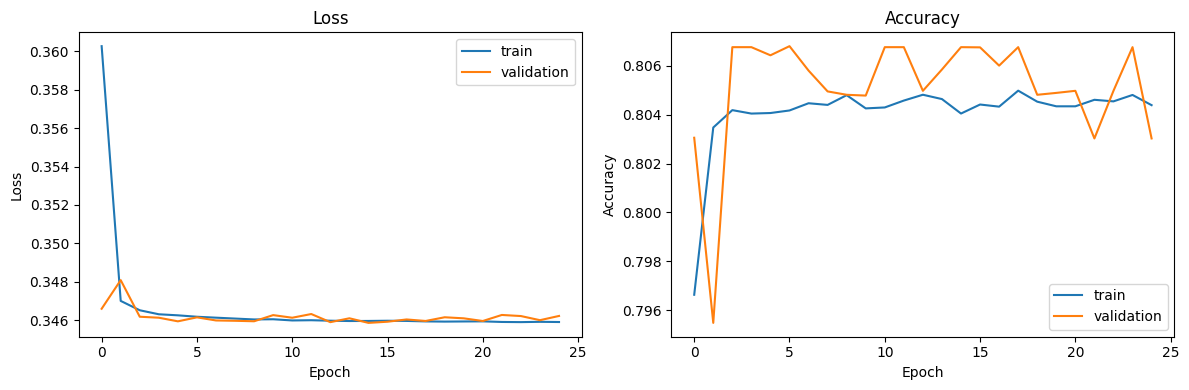

In [81]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12,4))

# 1) Loss
axes[0].plot(history.history['loss'], label='train')
axes[0].plot(history.history['val_loss'], label='validation')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# 2) Accuracy
axes[1].plot(history.history.get('accuracy', []), label='train')
axes[1].plot(history.history.get('val_accuracy', []), label='validation')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

## 테스트 데이터의 예측 결과 평가

In [82]:
pred_df = pd.DataFrame(pred, columns=['TAG'])

In [83]:
## 예측 결과는 0~1 사이의 값, 확률로 나타남.
pred_df[:4]

,TAG
0,0.766311
1,0.442346
2,0.751971
3,0.510993


In [84]:
pred_df.columns

Index(['TAG'], dtype='object')

In [85]:
pred_df['TAG_BINARY'] = pred_df.TAG.apply(lambda x: 1 if x >= 0.5 else 0)

In [86]:
pred_df.columns

Index(['TAG', 'TAG_BINARY'], dtype='object')

In [87]:
pred_df[:4]

,TAG,TAG_BINARY
0,0.766311,1
1,0.442346,0
2,0.751971,1
3,0.510993,1


In [88]:
pred_df.TAG.value_counts()

TAG
1.000000    25043
0.999999     8664
0.999999     7692
0.999999     3627
0.999999     3358
            ...  
0.769273        1
0.440021        1
0.755723        1
0.510180        1
0.799286        1
Name: count, Length: 169432, dtype: int64

In [89]:
pred_df.TAG_BINARY.value_counts()

TAG_BINARY
1    200296
0     50254
Name: count, dtype: int64

## Confusion Matrix (혼동 행렬)

In [90]:
classify = confusion_matrix(test_label, pred_df.TAG_BINARY)

In [91]:
classify

array([[  2155,    785],
       [ 48099, 199511]])

In [92]:
precision = precision_score(test_label, pred_df.TAG_BINARY)
print(f'precision: {precision: .4f}, {precision: .2%}')

precision:  0.9961,  99.61%


In [93]:
recall = recall_score(test_label, pred_df.TAG_BINARY)
print(f'recall: {recall: .4f}, {recall: .2%}')

recall:  0.8057,  80.57%


In [94]:
accuracy = accuracy_score(test_label, pred_df.TAG_BINARY)
print(f'accuracy: {accuracy: .4f}, {accuracy: .2%}')

accuracy:  0.8049,  80.49%


In [95]:
f1 = f1_score(test_label, pred_df.TAG_BINARY)
print(f'f1: {f1: .4f}, {f1: .2%}')

f1:  0.8909,  89.09%


## 분석 결과 해석

### 품질 관리(공정) 관점에서 해석

| 지표 | 값 | 결과 해석 | 공정 의미 | 위험 요인 |
|:------|:------:|:-----------|:-----------|:-----------|
| **정밀도 (Precision)** | **99.61%** | 매우 높음 | OK라고 판단할 때 거의 확실함 | 정상 제품을 지나치게 보수적으로 판단 (엄격한 필터링) |
| **재현율 (Recall)** | **80.63%** | 양호 | OK 제품의 약 80%를 올바르게 식별 | 정상 제품 일부를 불량으로 오판 가능 (폐기 증가) |
| **정확도 (Accuracy)** | **80.54%** | 중간 수준 | 전체 분류 정확도 80%로 준수한 수준 | 클래스 불균형의 영향이 존재 |
| **F1-score** | **89.12%** | 균형적 | Precision과 Recall의 절충형 성능 | Precision 중심의 보수적 모델 특성 유지 |



현재 모델은 **“정상(OK) 판단을 매우 신중하게 수행하는 보수적 모델”**로 평가  
즉, **OK(정상)** 예측 시 오탐(False Positive)이 거의 없으며, **확실할 때만 OK로 판단**

- **장점** : FP(오탐)가 거의 없어 불량품 출하 위험이 매우 낮음 
- **단점** : FN(정상인데 불량으로 예측)이 다소 많아, 불필요한 정상 제품 폐기 발생 
- **현재 상태** : OK로 예측하는 기준이 매우 엄격하여, 생산 품질 안정성은 확보되지만 생산 효율이 낮은 편 


### 개선 방향 제안

1. **재현율(Recall) 향상 중심 조정**
   - 정상 제품을 더 많이 OK로 분류하도록 민감도를 높임  
   - 방법 
     - 분류 임계값(Threshold) 조정  
     - SMOTE 재적용 또는 클래스 가중치 조정  
     - LSTM 모델 파라미터 튜닝(뉴런 수, dropout 등)

2. **Precision–Recall 균형 조정**
   - Precision이 매우 충분하므로 약간의 감소를 허용하면서 Recall 향상  
   - F1-score가 0.9에 근접하므로, trade-off 조정을 통해 더 균형 잡힌 모델 설계 가능


### 결론

> - 본 모델은 **정상 판정에 신중한, Precision 중심의 보수적 모델**  
> - 불량 제품의 오탐 위험은 거의 없으나, 정상 제품 일부가 과잉 탐지되어 생산 효율이 낮은 경향 존재  
> - 향후 **Recall 향상과 Precision–Recall 균형 조정**을 통해 품질 안정성과 생산 효율을 모두 확보하는 방향으로 모델을 개선할 필요가 있음

In [96]:
# ==== 1) 아티팩트 저장 경로 구성 ====
from pathlib import Path
from joblib import dump
import json
import shutil

ARTIFACT_DIR = Path("artifacts")       # 스케일러/메타데이터
ARTIFACT_DIR.mkdir(exist_ok=True, parents=True)

MODEL_DIR = Path("model")  
best_model_path = MODEL_DIR / "best_model.keras"

# ==== 2) 스케일러 저장 (MinMaxScaler) ====
# 노트북 상단에서 이미 생성/학습된 MinMaxScaler 인스턴스가 'scaler' 라는 이름으로 존재해야 함
scaler_path = ARTIFACT_DIR / "minmax_scaler.joblib"
dump(scaler, scaler_path)
# print(f"[OK] Saved scaler  -> {scaler_path.resolve()}")
print(f"[OK] Saved scaler")

# ==== 3) 메타데이터(추론에 필요한 부가 정보) 저장 ====
# 학습 때 사용한 피처 이름, 윈도우 크기, 임계값(있으면) 등을 남겨두면 운영 추론 파이프라인에 매우 유용합니다.
# 아래 값들은 노트북의 실제 변수명으로 바꿔주세요.
FEATURE_COLUMNS = ["MELT_TEMP", "MOTORSPEED"]   # <- 실제 사용한 입력 피처 목록으로 수정
WINDOW_SIZE     = 10                             # <- make_dataset(window_size=...)에서 썼던 값
THRESHOLD       = 0.5                            # <- 이진 분류에서 확률 임계값을 따로 쓴다면 기록

meta = {
    "feature_columns": FEATURE_COLUMNS,
    "window_size": WINDOW_SIZE,
    "threshold": THRESHOLD,
    "scaler_path": str(scaler_path),
    "model_path": str(best_model_path),
    "framework": "tensorflow-keras",
    "saved_from": "Baseline-lstm.ipynb"
}

meta_path = ARTIFACT_DIR / "inference_meta.json"
with open(meta_path, "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)
# print(f"[OK] Saved meta    -> {meta_path.resolve()}")
print(f"[OK] Saved meta")


[OK] Saved scaler
[OK] Saved meta
